In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras

# Load datasets
dominant_data = pd.read_csv("eog_dominant.csv")
both_data = pd.read_csv("both_eyes.csv")

# Combine datasets (assuming both have the same format)
data = pd.concat([dominant_data, both_data], ignore_index=True)

# Define thresholds
def classify_amplitude(amplitude):
    if amplitude > 28.0:
        return "left"
    elif amplitude <= 18.0:
        return "right"
    elif 24 <= amplitude <= 28:
        return "Saccade"
    else:
        return "Neutral"


data['Class'] = data['amplified_voltage'].apply(classify_amplitude)

# Encode labels
class_mapping = {'Neutral': 3, 'right': 2, 'Saccade': 1, 'left': 0}
data['Class'] = data['Class'].map(class_mapping)

# Features and labels
X = data[['amplified_voltage']].values
y = data['Class'].values

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [33]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten

window_size = 60  # Adjust based on your sampling rate
num_classes = 4

# Build a simple neural network model
model = Sequential([
    Conv1D(32, kernel_size=4, activation='relu', input_shape=(window_size, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(16, return_sequences=True),
    LSTM(8),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')  # Adjust for your classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# # Save the model as .tflite
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# with open("eye_movement_model.tflite", "wb") as f:
#     f.write(tflite_model)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 0, 32)               │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 0, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 0, 16)               │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │              68 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,308 (16.83 KB)

 Trainable params: 4,308 (16.83 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Prediction code

# Example data for prediction (replace with your own values or live data)
new_amplitudes = np.array([17.9, 25.0, 30.0])  # Example voltage values

# Scale the input data using the same scaler used during training
new_amplitudes_scaled = scaler.transform(new_amplitudes.reshape(-1, 1))

# Make predictions
predictions = model.predict(new_amplitudes_scaled)

# Get the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Map the numerical classes back to their labels
reverse_class_mapping = {v: k for k, v in class_mapping.items()}
predicted_labels = [reverse_class_mapping[cls] for cls in predicted_classes]

# Print the predictions
for amplitude, prediction, label in zip(new_amplitudes, predictions, predicted_labels):
    print(f"Amplitude: {amplitude:.2f}, Predicted Probabilities: {prediction}, Predicted Class: {label}")


ValueError: Exception encountered when calling Conv1D.call().

[1mNegative dimension size caused by subtracting 4 from 1 for '{{node sequential_3_1/conv1d_3_1/convolution}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_3_1/conv1d_3_1/convolution/ExpandDims, sequential_3_1/conv1d_3_1/convolution/ExpandDims_1)' with input shapes: [3,1,1,1], [1,4,1,32].[0m

Arguments received by Conv1D.call():
  • inputs=tf.Tensor(shape=(3, 1, 1), dtype=float32)

In [ ]:
dominant_data

,Timestamp,Voltage,filtered_voltage,amplified_voltage
0,223095,2.419,2.417,24.189
1,223110,2.410,2.422,24.099
2,223125,2.407,2.422,24.066
3,223140,2.396,2.421,23.964
4,223155,2.397,2.420,23.967
...,...,...,...,...
6811,586500,1.898,1.752,18.979
6812,586515,1.922,1.773,19.216
6813,586530,1.951,1.799,19.507
6814,586545,2.008,1.832,20.077


In [ ]:
# prompt: Using dataframe dominant_data: use time series and create a sample window where. the rapid signal changes occures

# Import necessary libraries
import pandas as pd
import numpy as np

# Assuming 'dominant_data' is your DataFrame

# Calculate the rolling standard deviation of the amplified voltage to identify rapid changes
window_size = 60  # Adjust the window size as needed
dominant_data['rolling_std'] = dominant_data['amplified_voltage'].rolling(window=window_size).std()
both_data['rolling_std'] = both_data['amplified_voltage'].rolling(window=window_size).std()

# Find the time points where the rolling standard deviation exceeds a threshold
threshold = 0.5  # Adjust the threshold as needed to capture significant changes.
rapid_change_indices = dominant_data[dominant_data['rolling_std'] > threshold].index
both_rapid_change_indices = both_data[both_data['rolling_std'] > threshold].index

# Create a sample window around the detected rapid changes
window_width = 50  # Adjust the window width as needed.
sample_windows = []

for index_list in [both_rapid_change_indices, rapid_change_indices]:
    for index in index_list:
        start_index = max(0, index - window_width)
        end_index = min(len(dominant_data), index + window_width)
        sample_windows.append(dominant_data.iloc[start_index:end_index])

# Concatenate the sample windows into a single DataFrame
if sample_windows:
    sample_df = pd.concat(sample_windows)
    sample_df2 = pd.concat(sample_windows)
else:
    # Handle cases where no rapid changes were found above the threshold
    print("No rapid changes detected above the specified threshold.")
    sample_df = dominant_data.head(0) # Return an empty DataFrame to avoid errors
    sample_df2 = both_data.head(0) # Return an empty DataFrame to avoid errors

# Save the sample DataFrame for further analysis
sample_df.to_csv("sample_windows.csv", index=False)
sample_df2.to_csv("both_sample_windows.csv", index=False)

# Display the first few rows of the sample DataFrame
print(sample_df.head())
print(sample_df2.head())

   Timestamp  Voltage  filtered_voltage  amplified_voltage  rolling_std
15     48630    2.464             2.474             24.641          NaN
16     48630    2.464             2.474             24.641          NaN
17     48630    2.464             2.474             24.641          NaN
18     48630    2.464             2.474             24.641          NaN
19     48640    2.473             2.473             24.734          NaN
   Timestamp  Voltage  filtered_voltage  amplified_voltage  rolling_std
15     48630    2.464             2.474             24.641          NaN
16     48630    2.464             2.474             24.641          NaN
17     48630    2.464             2.474             24.641          NaN
18     48630    2.464             2.474             24.641          NaN
19     48640    2.473             2.473             24.734          NaN


In [ ]:
sample_df

,Timestamp,Voltage,filtered_voltage,amplified_voltage,rolling_std
9,223230,2.449,2.413,24.490,NaN
10,223245,2.432,2.414,24.324,NaN
11,223260,2.395,2.412,23.949,NaN
12,223275,2.429,2.415,24.288,NaN
13,223290,2.449,2.420,24.487,NaN
...,...,...,...,...,...
6811,586500,1.898,1.752,18.979,4.560354
6812,586515,1.922,1.773,19.216,4.611587
6813,586530,1.951,1.799,19.507,4.659537
6814,586545,2.008,1.832,20.077,4.680101


In [ ]:
sample_df.to_csv('sample_data.csv', index=False)

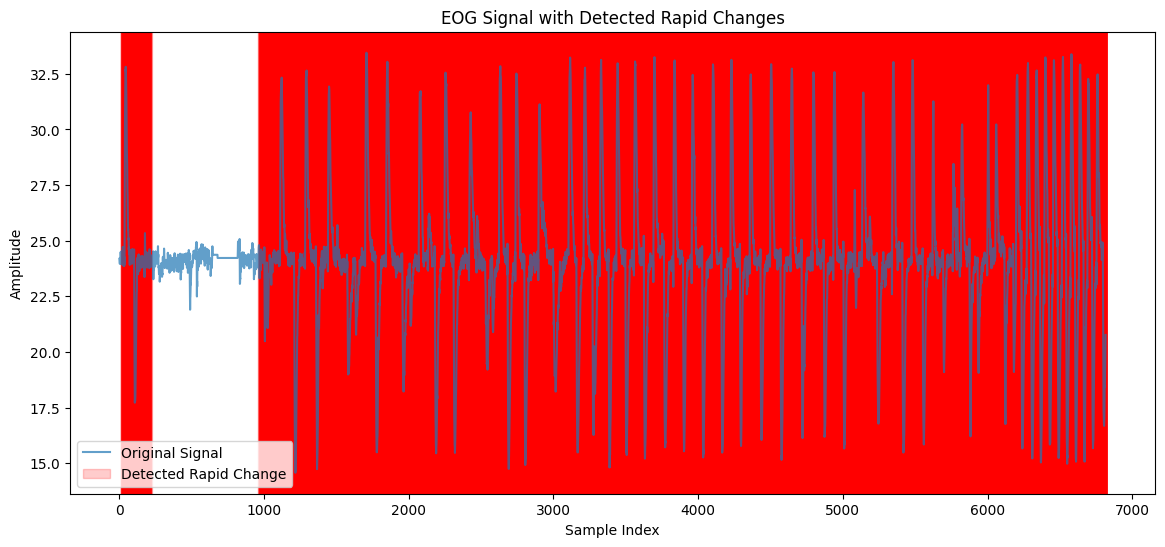

Extracted 5499 rapid change windows.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'dominant_data' is your DataFrame

# Parameters for rolling standard deviation and windowing
window_size = 60  # Adjust based on the duration of expected changes
threshold = 0.9  # Adjust to control sensitivity
window_width = 50  # Number of points before and after a rapid change

# Calculate rolling standard deviation
dominant_data['rolling_std'] = dominant_data['amplified_voltage'].rolling(window=window_size).std()

# Detect indices with significant changes
rapid_change_indices = dominant_data[dominant_data['rolling_std'] > threshold].index

# Visualize the data
plt.figure(figsize=(14, 6))
plt.plot(dominant_data['amplified_voltage'], label='Original Signal', alpha=0.7)

# Highlight detected rapid change regions
for index in rapid_change_indices:
    start_index = max(0, index - window_width)
    end_index = min(len(dominant_data), index + window_width)
    plt.axvspan(start_index, end_index, color='red', alpha=0.2, label='Detected Rapid Change' if index == rapid_change_indices[0] else "")

# Add labels and legend
plt.title("EOG Signal with Detected Rapid Changes")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# Extract and combine the windows into a single DataFrame
sample_windows1 = []
for index in rapid_change_indices:
    start_index = max(0, index - window_width)
    end_index = min(len(dominant_data), index + window_width)
    sample_windows1.append(dominant_data.iloc[start_index:end_index])

# Concatenate all windows
if sample_windows1:
    sample_df1 = pd.concat(sample_windows1)
    print(f"Extracted {len(sample_windows1)} rapid change windows.")
else:
    print("No rapid changes detected above the specified threshold.")
    sample_df1 = dominant_data.head(0)  # Empty DataFrame

# Save sample DataFrame for further analysis
sample_df1.to_csv("sample_windows.csv", index=False)


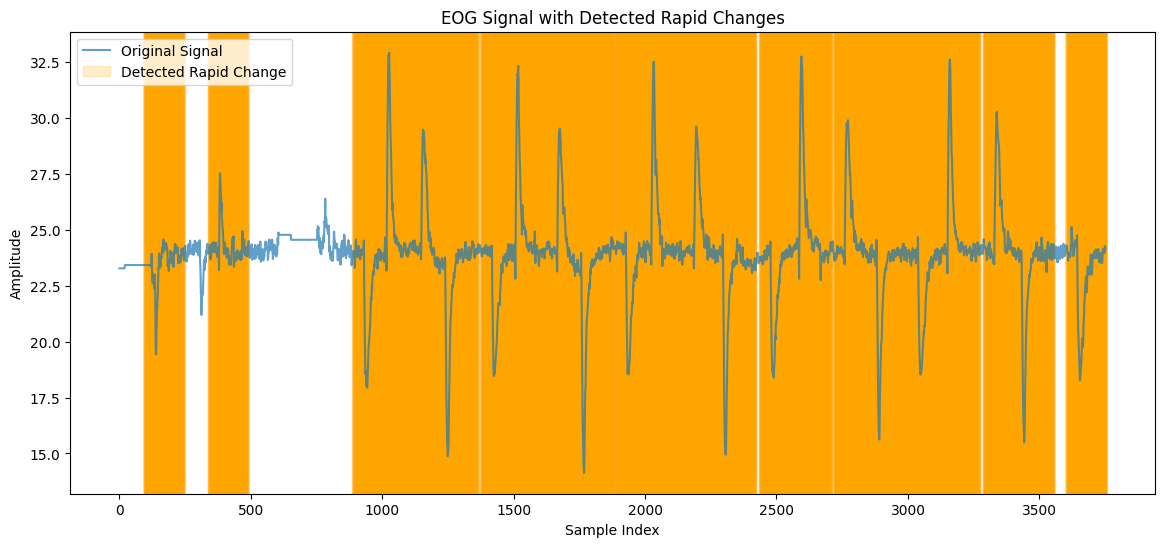

Extracted 1683 rapid change windows.


In [20]:
# Assuming 'both_data' is your DataFrame

# Parameters for rolling standard deviation and windowing
window_size = 60  # Adjust based on the duration of expected changes
threshold = 0.9  # Adjust to control sensitivity
window_width = 50  # Number of points before and after a rapid change

# Calculate rolling standard deviation
both_data['rolling_std'] = both_data['amplified_voltage'].rolling(window=window_size).std()

# Detect indices with significant changes
rapid_change_indices = both_data[both_data['rolling_std'] > threshold].index

# Visualize the data
plt.figure(figsize=(14, 6))
plt.plot(both_data['amplified_voltage'], label='Original Signal', alpha=0.7)

# Highlight detected rapid change regions
for index in rapid_change_indices:
    start_index = max(0, index - window_width)
    end_index = min(len(both_data), index + window_width)
    plt.axvspan(start_index, end_index, color='orange', alpha=0.2, label='Detected Rapid Change' if index == rapid_change_indices[0] else "")

# Add labels and legend
plt.title("EOG Signal with Detected Rapid Changes")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# Extract and combine the windows into a single DataFrame
sample_windows2 = []
for index in rapid_change_indices:
    start_index = max(0, index - window_width)
    end_index = min(len(dominant_data), index + window_width)
    sample_windows2.append(dominant_data.iloc[start_index:end_index])

# Concatenate all windows
if sample_windows2:
    sample_df2 = pd.concat(sample_windows2)
    print(f"Extracted {len(sample_windows2)} rapid change windows.")
else:
    print("No rapid changes detected above the specified threshold.")
    sample_df2 = both_data.head(0)  # Empty DataFrame

# Save sample DataFrame for further analysis
sample_df2.to_csv("sample_windows2.csv", index=False)


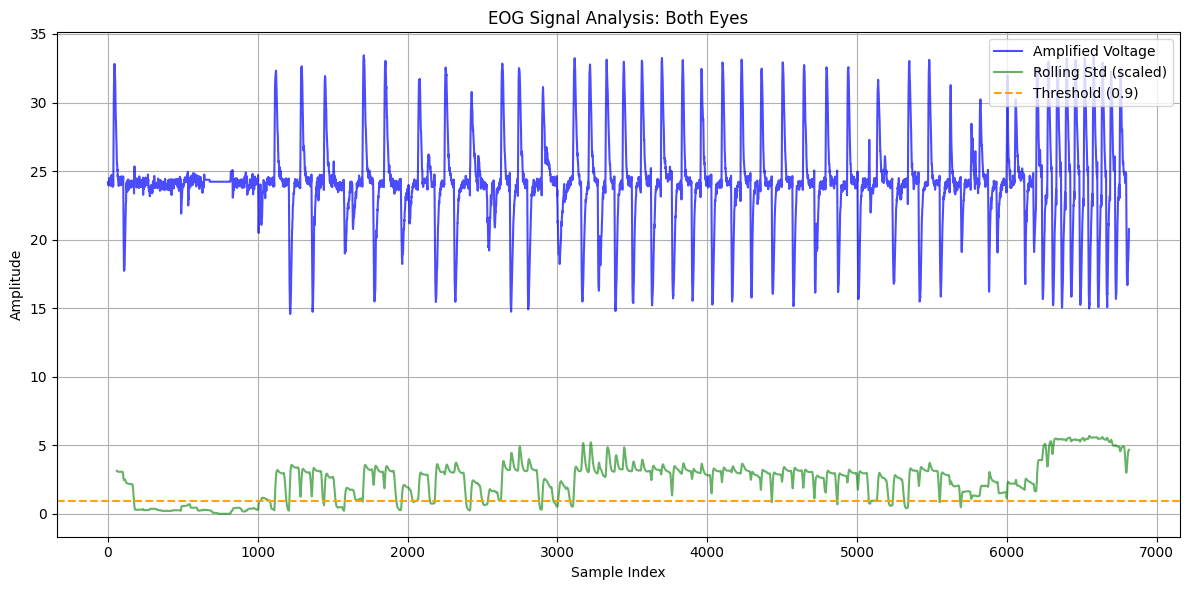

In [26]:
import matplotlib.pyplot as plt

sample_windows = pd.read_csv("sample_windows.csv")

# Plot the amplified voltage and highlight rapid changes
plt.figure(figsize=(12, 6))

# Original signal
plt.plot(dominant_data.index, dominant_data['amplified_voltage'], label='Amplified Voltage', color='blue', alpha=0.7)

# Highlight regions of rapid change
if sample_df1.empty:
    for _, window in sample_windows:
        plt.axvspan(window.index[0], window.index[-1], color='red', alpha=0.3, label='Rapid Change Region')

# Rolling standard deviation for reference
plt.plot(dominant_data.index, dominant_data['rolling_std'], label='Rolling Std (scaled)', color='green', alpha=0.6)

# Add threshold line
plt.axhline(y=threshold, color='orange', linestyle='--', label=f'Threshold ({threshold})')

# Add labels and legend
plt.title('EOG Signal Analysis: Both Eyes')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

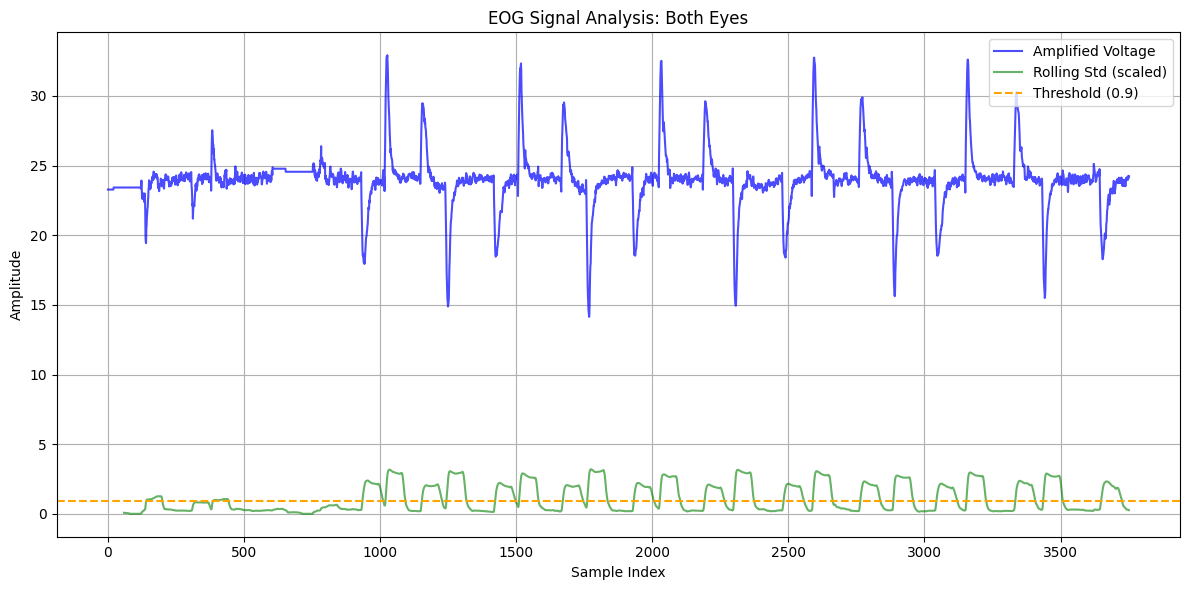

In [27]:
import matplotlib.pyplot as plt

sample_windows2 = pd.read_csv("sample_windows2.csv")

# Plot the amplified voltage and highlight rapid changes
plt.figure(figsize=(12, 6))

# Original signal
plt.plot(both_data.index, both_data['amplified_voltage'], label='Amplified Voltage', color='blue', alpha=0.7)

# Highlight regions of rapid change
if sample_df2.empty:
    for _, window in sample_windows:
        plt.axvspan(window.index[0], window.index[-1], color='red', alpha=0.3, label='Rapid Change Region')

# Rolling standard deviation for reference
plt.plot(both_data.index, both_data['rolling_std'], label='Rolling Std (scaled)', color='green', alpha=0.6)

# Add threshold line
plt.axhline(y=threshold, color='orange', linestyle='--', label=f'Threshold ({threshold})')

# Add labels and legend
plt.title('EOG Signal Analysis: Both Eyes')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the CSV file
data = pd.read_csv("eog_dominant.csv")  # Replace with the correct CSV filename

# Define thresholds for classifying eye movements
def classify_amplitude(amplitude):
    if amplitude > 30.0:
        return 2  # High
    elif amplitude < 18.0:
        return 0  # Low
    else:
        return 1  # Neutral

# Add class labels
data['Class'] = data['amplified_voltage'].apply(classify_amplitude)

# Extract features and labels
X = data[['amplified_voltage']].values
y = data['Class'].values

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Segment data into windows
def segment_signal(data, window_size=128):
    segments = []
    for i in range(0, len(data) - window_size + 1, window_size):
        segments.append(data[i:i + window_size])
    return np.array(segments)

window_size = 128  # Define your preferred window size
X_segments = segment_signal(X_scaled)
y_segments = segment_signal(y.reshape(-1, 1)).squeeze()  # Align labels with segments

# Ensure labels are consistent across each segment (majority voting or single class per segment)
y_final = np.array([np.bincount(segment).argmax() for segment in y_segments])

# Save the processed data as numpy arrays
np.save("eog_features.npy", X_segments)
np.save("eog_labels.npy", y_final)

print("Data saved successfully as numpy arrays!")


Data saved successfully as numpy arrays!


In [ ]:
X = np.load("eog_features.npy")
y = np.load("eog_labels.npy")
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])